### 01. IMPORTS


In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
import math
import itertools
import pprint
from tqdm import tqdm

### 02. PARAMETERS


#### MODELING


In [276]:
CAPEX = {
    "fixed": {
        "original": 162_000, 
        "additional": 96_000, 
    }, 
    "variable_injection": {
        "fixed": 2_400, 
        "variable": 1.5, 
    }, 
    "variable_extraction": {
        "fixed": 14_000, 
        "variable": 10.6, 
    },
}

OPEX = {}

VALUES = {
    "well_flow": 150/17, # m3/h
    "avg_concentration": 40, # mg/L
    "uranium_value" : 188.306 # $/kg
}


# map

def get_hexagon(center, size):
    """Generate the vertices of a hexagon given a center and size."""
    angles = np.linspace(0, 2 * np.pi, 7)
    x_hex = center[0] + size * np.cos(angles)
    y_hex = center[1] + size * np.sin(angles)
    z_hex = center[2] + np.zeros(7)
    return x_hex, y_hex, z_hex

def get_hexagonal_structure(size, hexagons):
    hexagonal_structure = {}
    h_dist = 3/2 * size
    v_dist = np.sqrt(3) * size
    id_hex = 0
    for col, row, h in hexagons:
        x = col * h_dist
        y = row * v_dist
        if col % 2 == 1:
            y += v_dist / 2
        x_hex, y_hex, z_hex = get_hexagon((x, y, h), size)
        hexagonal_structure.update({
            id_hex: {
                "x_hex": x_hex, "y_hex": y_hex, "z_hex": z_hex, 
                "x_center": np.mean(x_hex), "y_center": np.mean(y_hex), "z_center": np.mean(z_hex)
            }
        })
        id_hex += 1
    
    return hexagonal_structure

def plot_hexagonal_structure(size, hexagons_to_draw):
    """Plot a hexagonal structure drawing only specified hexagons."""
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    hex_structure = get_hexagonal_structure(size, hexagons_to_draw)
    for hex in hex_structure.values():
        x_hex, y_hex = hex["x_hex"], hex["y_hex"]
        ax.plot(x_hex, y_hex, '-', color='black')
    
    plt.axis('off')
    plt.show()


# Tuz positions

def get_positions_tuz(hexagonal_structure, N_tuz):
    X = [[hexagon["x_center"], hexagon["y_center"]] for hexagon in hexagonal_structure.values()]
    kmeans =  KMeans(N_tuz, random_state=0, n_init="auto").fit(X)
    labels =  kmeans.labels_
    centroids = kmeans.cluster_centers_
    for i, hexagon in hexagonal_structure.items():
        hexagon.update({
            "cluster_id": labels[i], 
            "x_cluster_center": centroids[labels[i]][0], 
            "y_cluster_center": centroids[labels[i]][1]
        })
    tuzs = {
        i: {"x": centroid[0], 
            "y": centroid[1], 
            "z": 0, # to be updated according to data altitude
            "injection_points": [], 
            "extraction_points": [], 
        } for i, centroid in enumerate(centroids)} 
    
    return hexagonal_structure, tuzs

def plot_cells_tuzs(hexagonal_structure, tuzs):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    N_tuz = len(tuzs)
    cmap = ListedColormap(plt.get_cmap('viridis')(np.linspace(0, 1, N_tuz)))
    colors = [cmap(i) for i in range(N_tuz)]
    for hex in hexagonal_structure.values():
        x_hex, y_hex = hex["x_hex"], hex["y_hex"]
        ax.plot(x_hex, y_hex, '-', color=colors[hex["cluster_id"]])
    
    for i, tuz in tuzs.items(): 
        ax.plot(tuz["x"], tuz["y"], '+', color=colors[i])
    
    plt.axis('off')
    plt.show()


# costs modeling

def get_distance(x1, y1, z1, x2, y2, z2):
    return np.linalg.norm(np.array([x1, y1, z1]) - np.array([x2, y2, z2]))

def get_vertices(hexagonal_structure, tolerance=1e-2):
    vertices = {}
    vertex_id = 0
    vertex_map = {}

    for hex_id, hex_data in hexagonal_structure.items():
        x_hex = hex_data["x_hex"]
        y_hex = hex_data["y_hex"]
        z_hex = hex_data["z_hex"]

        for i in range(len(x_hex)):
            vertex = (x_hex[i], y_hex[i], z_hex[i])
            matched = False

            for existing_vertex in vertex_map:
                if np.allclose(vertex, existing_vertex, atol=tolerance):
                    vertices[vertex_map[existing_vertex]]["related_hexagons_ids"].append(hex_id)
                    matched = True
                    break

            if not matched:
                vertex_map[vertex] = vertex_id
                vertices[vertex_id] = {
                    "vertex_position_x": x_hex[i],
                    "vertex_position_y": y_hex[i],
                    "vertex_position_z": z_hex[i],
                    "related_hexagons_ids": [hex_id]
                }
                vertex_id += 1
    for vertex in vertices.values():
        vertex["related_hexagons_ids"] = list(np.unique(vertex["related_hexagons_ids"]))
    return vertices

def get_lines(hexagonal_structure, vertices, tuzs):
    extraction_lines = {
        hexagon_id: {
            "x_from": tuzs[hexagon_info["cluster_id"]]["x"],
            "y_from": tuzs[hexagon_info["cluster_id"]]["y"],
            "z_from": tuzs[hexagon_info["cluster_id"]]["z"],
            
            "x_to": hexagon_info["x_center"], 
            "y_to": hexagon_info["y_center"], 
            "z_to": hexagon_info["z_center"], 
        }
        for hexagon_id, hexagon_info in hexagonal_structure.items()
    }
    for hexagon_id, hexagon_info in hexagonal_structure.items():
        tuzs[hexagon_info["cluster_id"]]["extraction_points"].append(hexagon_id)
    
    injection_lines = {}
    for i, vertex in vertices.items():
        hexagon_ids = vertex["related_hexagons_ids"]
        candidate_tuzs_ids = list(set(hexagonal_structure[hexagon_id]["cluster_id"] for hexagon_id in hexagon_ids))
        candidate_tuzs = {key: val for key, val in tuzs.items() if key in candidate_tuzs_ids}
        distances_tuzs = {
            tuz_id: get_distance(
                vertex["vertex_position_x"], vertex["vertex_position_y"], vertex["vertex_position_z"], 
                tuz_info["x"], tuz_info["y"], tuz_info["z"]
            )
        for tuz_id, tuz_info in candidate_tuzs.items()
        }
        selected_tuz_id = next(iter(distances_tuzs)) if len(distances_tuzs)==1 else min(distances_tuzs, key=distances_tuzs.get)
        tuzs[selected_tuz_id]["injection_points"].append(i)
        injection_lines.update({
            i : {
                "id_from": i, 
                
                "x_from": vertex["vertex_position_x"], 
                "y_from": vertex["vertex_position_y"], 
                "z_from": vertex["vertex_position_z"], 
                
                "x_to": tuzs[selected_tuz_id]["x"], 
                "y_to": tuzs[selected_tuz_id]["y"], 
                "z_to": tuzs[selected_tuz_id]["z"], 
            },
        })
    return injection_lines, extraction_lines

def plot_cells_tuzs_lines(hexagonal_structure, tuzs, injection_lines, extraction_lines):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    N_tuz = len(tuzs)
    cmap = ListedColormap(plt.get_cmap('viridis')(np.linspace(0, 1, N_tuz)))
    colors = [cmap(i) for i in range(N_tuz)]
    for hex in hexagonal_structure.values():
        x_hex, y_hex = hex["x_hex"], hex["y_hex"]
        ax.plot(x_hex, y_hex, '-', color=colors[hex["cluster_id"]])
    
    for i, tuz in tuzs.items(): 
        ax.plot(tuz["x"], tuz["y"], '+', color=colors[i])
    
    for injection_line in injection_lines.values():
        ax.plot(
            [injection_line["x_from"], injection_line["x_to"]], 
            [injection_line["y_from"], injection_line["y_to"]], 
            '--', color="blue"
        )
    for extraction_line in extraction_lines.values():
        ax.plot(
            [extraction_line["x_from"], extraction_line["x_to"]], 
            [extraction_line["y_from"], extraction_line["y_to"]], 
            '--', color="red"
        )
    plt.axis('off')
    plt.show()

# def get_costs(tuzs, injection_lines, extraction_lines, cost_params):
#     fixed_cost, variable_costs = 0, 0
#     fixed_cost += len(tuzs) * cost_params["fixed"]["original"]
#     for tuz in tuzs.values():
#         fixed_cost += len(tuz["extraction_points"])//20 * cost_params["fixed"]["additional"]
#     for injection_line in injection_lines.values():
#         distance = get_distance(
#             injection_line["x_from"], 
#             injection_line["y_from"], 
#             injection_line["z_from"], 
#             injection_line["x_to"], 
#             injection_line["y_to"], 
#             injection_line["z_to"], 
#         )
#         variable_costs += cost_params["variable_injection"]["fixed"]
#         variable_costs += cost_params["variable_injection"]["variable"] * distance
#     for extraction_line in extraction_lines.values():
#         distance = get_distance(
#             extraction_line["x_from"], 
#             extraction_line["y_from"], 
#             extraction_line["z_from"], 
#             extraction_line["x_to"], 
#             extraction_line["y_to"], 
#             extraction_line["z_to"], 
#         )
#         variable_costs += cost_params["variable_extraction"]["fixed"]
#         variable_costs += cost_params["variable_extraction"]["variable"] * distance
#     # total_cost = fixed_cost + variable_costs
#     return fixed_cost, variable_costs

def get_costs(tuzs, injection_lines, extraction_lines, cost_params):
    fixed_original, fixed_additional = 0, 0
    variable_injection, variable_injection_linear = 0, 0
    variable_extraction, variable_extraction_linear = 0, 0
    fixed_original += len(tuzs) * cost_params["fixed"]["original"]
    for tuz in tuzs.values():
        fixed_additional += len(tuz["extraction_points"])//20 * cost_params["fixed"]["additional"]
    for injection_line in injection_lines.values():
        distance = get_distance(
            injection_line["x_from"], 
            injection_line["y_from"], 
            injection_line["z_from"], 
            injection_line["x_to"], 
            injection_line["y_to"], 
            injection_line["z_to"], 
        )
        variable_injection += cost_params["variable_injection"]["fixed"]
        variable_injection_linear += cost_params["variable_injection"]["variable"] * distance
    for extraction_line in extraction_lines.values():
        distance = get_distance(
            extraction_line["x_from"], 
            extraction_line["y_from"], 
            extraction_line["z_from"], 
            extraction_line["x_to"], 
            extraction_line["y_to"], 
            extraction_line["z_to"], 
        )
        variable_extraction += cost_params["variable_extraction"]["fixed"]
        variable_extraction_linear += cost_params["variable_extraction"]["variable"] * distance
    return (
        fixed_original, fixed_additional, 
        variable_injection, variable_injection_linear, 
        variable_extraction, variable_extraction_linear
    )

def get_value(hexagonal_structure, value_params):
    """computes the value of the mine, expressed in $ / year

    Args:
        hexagonal_structure (Dict): geographical structure of the mine
        value_params (Dict): values parameter

    Returns:
        float: value of the mine
    """
    nb_hex = len(hexagonal_structure)
    value_well = value_params["well_flow"] * value_params["avg_concentration"] * value_params["uranium_value"] * 1e-3 * 24 * 365.25
    return nb_hex * value_well


# reporting 

def format_number(number):
    """
    Format a number with spaces as thousands separators.
    
    Args:
    number (int or float): The number to format.
    
    Returns:
    str: The formatted number as a string.
    """
    return f"{number:,}".replace(",", " ")

def print_summary(hexagons_to_draw, tuzs, costs, injection_lines, extraction_lines, value):
    # geography
    n_hex_x = max(hexagon[0] for hexagon in hexagons_to_draw) - min(hexagon[0] for hexagon in hexagons_to_draw) + 1
    n_hex_y = max(hexagon[1] for hexagon in hexagons_to_draw) - min(hexagon[1] for hexagon in hexagons_to_draw) + 1
    print(f'{len(tuzs)} TUZs')
    print(f'Grid : {len(hexagons_to_draw)} cells ({n_hex_x} x {n_hex_y})')
    print(28*'-')
    print('\n')

    print(f'• {round(np.mean([len(tuz["extraction_points"]) for tuz in tuzs.values()]), 1)} extraction points on average')
    print(f'• {round(np.mean([len(tuz["injection_points"]) for tuz in tuzs.values()]), 1)} injection points on average')
    print('\n')

    # costs
    (
        fixed_original, fixed_additional, 
        variable_injection, variable_injection_linear, 
        variable_extraction, variable_extraction_linear
    ) = costs
    total_cost = fixed_original + fixed_additional + variable_injection + variable_injection_linear + variable_extraction + variable_extraction_linear
    fixed_cost = fixed_original + fixed_additional
    variable_costs = total_cost - fixed_cost
    print(f'• Average TUZ cost : {format_number(round(total_cost / len(tuzs)))} €')
    print(f'   -> {round(100 * fixed_cost / total_cost)} % fixed costs')
    print(f'   -> {round(100 * variable_costs / total_cost)} % variable costs')
    print('\n')

    # avg distances 
    injection_distances, extraction_distances = [], []
    for injection_line in injection_lines.values():
            distance = get_distance(
                injection_line["x_from"], 
                injection_line["y_from"], 
                injection_line["z_from"], 
                injection_line["x_to"], 
                injection_line["y_to"], 
                injection_line["z_to"], 
            )
            injection_distances.append(distance)
    for extraction_line in extraction_lines.values():
            distance = get_distance(
                extraction_line["x_from"], 
                extraction_line["y_from"], 
                extraction_line["z_from"], 
                extraction_line["x_to"], 
                extraction_line["y_to"], 
                extraction_line["z_to"], 
            )
            extraction_distances.append(distance)
    print(f'• Average injection line length : {round(np.mean(injection_distances), 1)} m')
    print(f'• Average extraction line length : {round(np.mean(extraction_distances), 1)} m')
    print('\n')

    print('Value :')
    print(f'• Total : {format_number(round(value))} € per year')
    print(f'• {format_number(round(value / len(hexagons_to_draw)))} € per cell per year')

def plot_tuz_sizes(tuzs, standards=[]):
    n_extractions = [len(tuz["extraction_points"]) for tuz in tuzs.values()]
    plt.figure(figsize=(12, 6))
    plt.hist(n_extractions, edgecolor='black', align='left')
    for std_size in standards:
        plt.axvline(x=std_size, color='grey', linestyle='--')
    plt.xlabel('Number of extraction wells')
    plt.ylabel('Count')
    plt.title('TUZ sizes')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


#### DUMMY TEST

In [79]:
# parameters

N_tuz = 2 # Nb de TUZ
hex_size = 1 # Size of each hexagon
hexagons_to_draw = [
    (0, 1, 0),
    (1, 0, 0),
    (1, 1, 0),
    (2, 1, 0),
    (2, 2, 0),
    (3, 0, 0),
    (4, 1, 0),
    (5, 1, 0),
    (5, 2, 0),
    (5, 3, 0),
]  # List of (row, col) to draw.


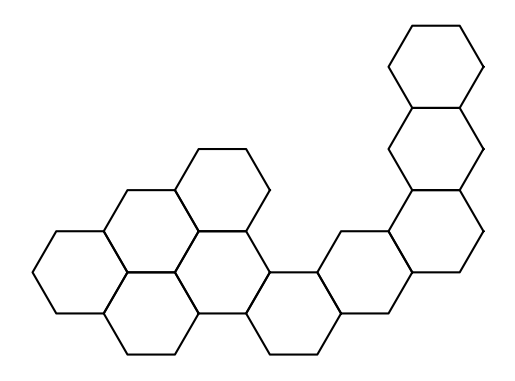

In [80]:
plot_hexagonal_structure(hex_size, hexagons_to_draw)

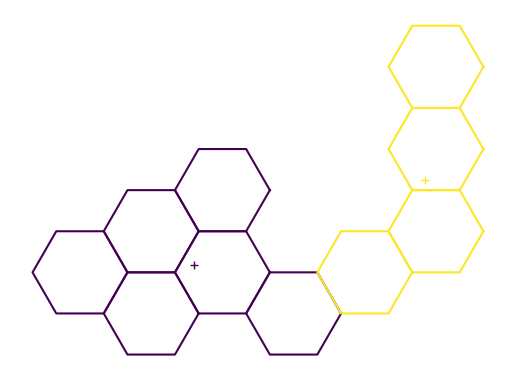

In [81]:
hexagonal_structure = get_hexagonal_structure(hex_size, hexagons_to_draw)
hexagonal_structure, tuzs = get_positions_tuz(hexagonal_structure, N_tuz)
plot_cells_tuzs(hexagonal_structure, tuzs)

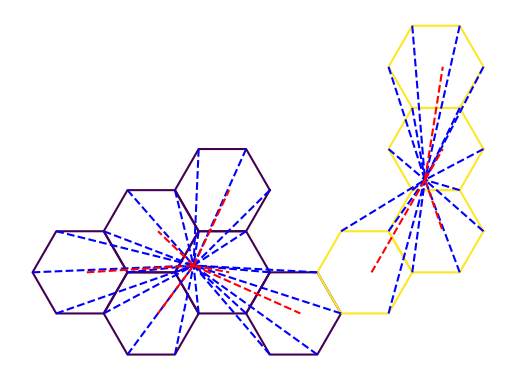

In [82]:
vertices = get_vertices(hexagonal_structure)
injection_lines, extraction_lines = get_lines(hexagonal_structure, vertices, tuzs)
plot_cells_tuzs_lines(hexagonal_structure, tuzs, injection_lines, extraction_lines)

#### EXAMPLE 30 x 15 cells

In [243]:
tuz_capa = 17
hex_size = 25 # Size of each hexagon
hexagons_to_draw = [
    (i, j, 0)
    for i in range(30)
    for j in range(15)
]
hexagonal_structure = get_hexagonal_structure(hex_size, hexagons_to_draw)
vertices = get_vertices(hexagonal_structure)

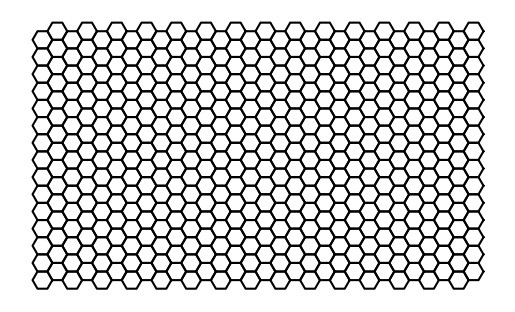

In [244]:
plot_hexagonal_structure(hex_size, hexagons_to_draw)

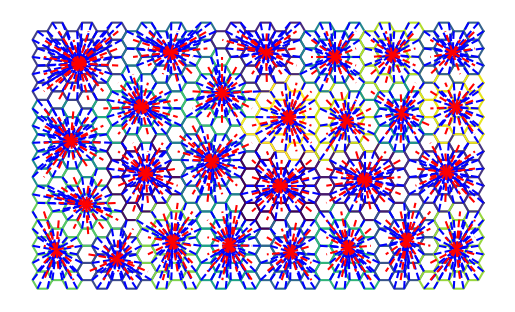

In [277]:
N_tuz = math.ceil(len(hexagons_to_draw) / tuz_capa)
hexagonal_structure, tuzs = get_positions_tuz(hexagonal_structure, N_tuz)

injection_lines, extraction_lines = get_lines(hexagonal_structure, vertices, tuzs)
costs = get_costs(tuzs, injection_lines, extraction_lines, CAPEX)
(
    fixed_original, fixed_additional, 
    variable_injection, variable_injection_linear, 
    variable_extraction, variable_extraction_linear
) = costs
value = get_value(hexagonal_structure, VALUES)
plot_cells_tuzs_lines(hexagonal_structure, tuzs, injection_lines, extraction_lines)

27 TUZs
Grid : 450 cells (30 x 15)
----------------------------


• 16.7 extraction points on average
• 36.7 injection points on average


• Average TUZ cost : 525 144 €
   -> 34 % fixed costs
   -> 66 % variable costs


• Average injection line length : 108.5 m
• Average extraction line length : 102.3 m


Value :
• Total : 262 168 475 € per year
• 582 597 € per cell per year


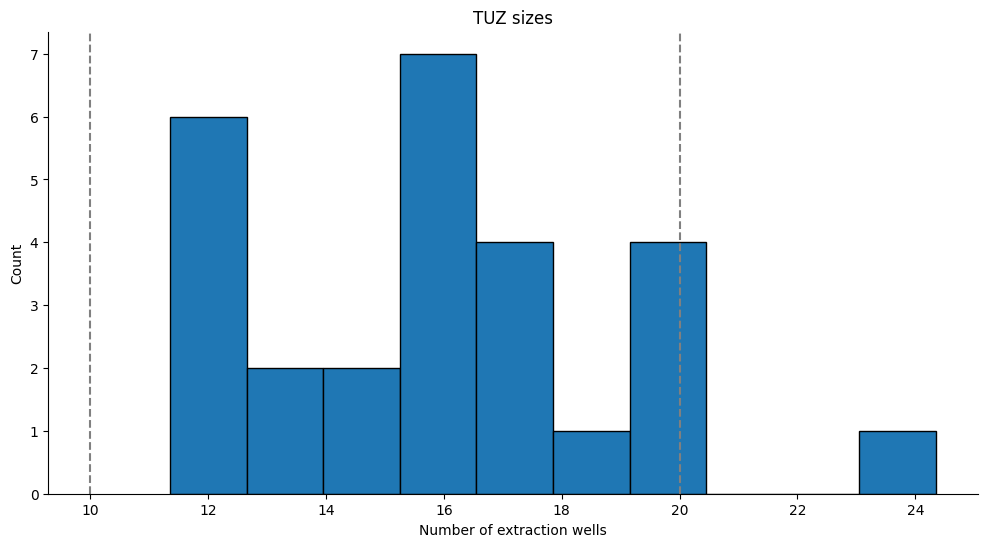

In [278]:
print_summary(hexagons_to_draw, tuzs, costs, injection_lines, extraction_lines, value)
plot_tuz_sizes(tuzs, standards=[10, 20])

#### TUZ CAPA TUNING w.r.t. COSTS & VALUES

In [281]:
hex_size = 40 # Size of each hexagon
hexagons_to_draw = [
    (i, j, 0)
    for i in range(30)
    for j in range(15)
]
hexagonal_structure = get_hexagonal_structure(hex_size, hexagons_to_draw)
vertices = get_vertices(hexagonal_structure)

In [273]:
print_summary(hexagons_to_draw, tuzs, costs, injection_lines, extraction_lines, value)

27 TUZs
Grid : 450 cells (30 x 15)
----------------------------


• 16.7 extraction points on average
• 36.7 injection points on average


• Average TUZ cost : 525 144 €
   -> 34 % fixed costs
   -> 66 % variable costs


• Average injection line length : 108.5 m
• Average extraction line length : 102.3 m


Value :
• Total : 262 168 475 € per year
• 582 597 € per cell per year


In [ ]:
def plot_stacked_costs(
        tuz_capas,
        fixed_original_costs,
        fixed_additional_costs,
        variable_injection_costs,
        variable_injection_linear_costs,
        variable_extraction_costs,
        variable_extraction_linear_costs,
        hexagons_to_draw,
    ):
    costs = np.array(
        [
            fixed_original_costs,
            fixed_additional_costs,
            variable_injection_costs,
            variable_injection_linear_costs,
            variable_extraction_costs,
            variable_extraction_linear_costs,
        ]
    )
    max_value = np.sum(costs, axis=0).max() / len(hexagons_to_draw)
    labels = [
        "Fixed Original Costs",
        "Fixed Additional Costs",
        "Variable Injection Costs",
        "Variable Injection Linear Costs",
        "Variable Extraction Costs",
        "Variable Extraction Linear Costs",
    ]
    fig, ax = plt.subplots(figsize=(10, 6))
    scaled_costs = [
        [cost / len(hexagons_to_draw) for cost in costs_i] for costs_i in costs
    ]
    ax.stackplot(tuz_capas, scaled_costs, labels=labels)
    ax.legend(loc="upper left", ncol=3)
    ax.set_ylim(0, 1.3 * max_value)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Costs")
    ax.set_title("Stacked Filled Graph of Costs")
    return fig

def plot_avg_distances(tuz_capas, distances_extraction_wells):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(tuz_capas, distances_extraction_wells)
    ax.set_xlabel('Avg TUZ capacity (Number of extraction wells)')
    ax.set_ylabel('Distance')
    ax.set_title('Evolution of Avg distance to extraction well w.r.t TUZ capacity')
    return fig

def tune_tuz_capa(hexagons_to_draw, hexagonal_structure, vertices, min_capa=10, maxcapa=60):
    tuz_capas, values = [], []
    distances_extraction_wells = []
    fixed_original_costs, fixed_additional_costs = [], []
    variable_injection_costs, variable_injection_linear_costs = [], []
    variable_extraction_costs, variable_extraction_linear_costs = [], []

    for tuz_capa in tqdm(range(min_capa, maxcapa+1)):
        N_tuz = math.ceil(len(hexagons_to_draw) / tuz_capa)
        hexagonal_structure, tuzs = get_positions_tuz(hexagonal_structure, N_tuz)
        injection_lines, extraction_lines = get_lines(hexagonal_structure, vertices, tuzs)
        avg_distance_extraction = np.mean([
            get_distance(
                injection_line["x_from"], 
                injection_line["y_from"], 
                injection_line["z_from"], 
                injection_line["x_to"], 
                injection_line["y_to"], 
                injection_line["z_to"], 
            )
            for injection_line in injection_lines.values()
        ])
        costs = get_costs(tuzs, injection_lines, extraction_lines, CAPEX)
        (
            fixed_original, fixed_additional, 
            variable_injection, variable_injection_linear, 
            variable_extraction, variable_extraction_linear
        ) = costs
        value = get_value(hexagonal_structure, VALUES)
        tuz_capas.append(tuz_capa)
        values.append(value)
        fixed_original_costs.append(fixed_original)
        fixed_additional_costs.append(fixed_additional)
        variable_injection_costs.append(variable_injection)
        variable_injection_linear_costs.append(variable_injection_linear)
        variable_extraction_costs.append(variable_extraction)
        variable_extraction_linear_costs.append(variable_extraction_linear)
        distances_extraction_wells.append(avg_distance_extraction)

    return (
        tuz_capas, values, 
        distances_extraction_wells, 
        fixed_original_costs, fixed_additional_costs, 
        variable_injection_costs, variable_injection_linear_costs, 
        variable_extraction_costs, variable_extraction_linear_costs
    )

def results_tuning(elements):
    (
        tuz_capas, values, 
        distances_extraction_wells, 
        fixed_original_costs, fixed_additional_costs, 
        variable_injection_costs, variable_injection_linear_costs, 
        variable_extraction_costs, variable_extraction_linear_costs
    ) = elements
    
    stacked_costs_fig = plot_stacked_costs(
        tuz_capas,
        fixed_original_costs,
        fixed_additional_costs,
        variable_injection_costs,
        variable_injection_linear_costs,
        variable_extraction_costs,
        variable_extraction_linear_costs,
        hexagons_to_draw,
    )
    avg_distances_fig = plot_avg_distances(tuz_capas, distances_extraction_wells)
    
    return stacked_costs_fig, avg_distances_fig


In [299]:
tuz_capas, values = [], []
distances_extraction_wells = []
fixed_original_costs, fixed_additional_costs = [], []
variable_injection_costs, variable_injection_linear_costs = [], []
variable_extraction_costs, variable_extraction_linear_costs = [], []

for tuz_capa in tqdm(range(10, 61)):
    N_tuz = math.ceil(len(hexagons_to_draw) / tuz_capa)
    hexagonal_structure, tuzs = get_positions_tuz(hexagonal_structure, N_tuz)
    injection_lines, extraction_lines = get_lines(hexagonal_structure, vertices, tuzs)
    avg_distance_extraction = np.mean([
        get_distance(
            injection_line["x_from"], 
            injection_line["y_from"], 
            injection_line["z_from"], 
            injection_line["x_to"], 
            injection_line["y_to"], 
            injection_line["z_to"], 
        )
        for injection_line in injection_lines.values()
    ])
    costs = get_costs(tuzs, injection_lines, extraction_lines, CAPEX)
    (
        fixed_original, fixed_additional, 
        variable_injection, variable_injection_linear, 
        variable_extraction, variable_extraction_linear
    ) = costs
    value = get_value(hexagonal_structure, VALUES)
    tuz_capas.append(tuz_capa)
    values.append(value)
    fixed_original_costs.append(fixed_original)
    fixed_additional_costs.append(fixed_additional)
    variable_injection_costs.append(variable_injection)
    variable_injection_linear_costs.append(variable_injection_linear)
    variable_extraction_costs.append(variable_extraction)
    variable_extraction_linear_costs.append(variable_extraction_linear)
    distances_extraction_wells.append(avg_distance_extraction)

100%|██████████| 51/51 [00:01<00:00, 32.03it/s]


In [ ]:
# ajouter nb de tuz

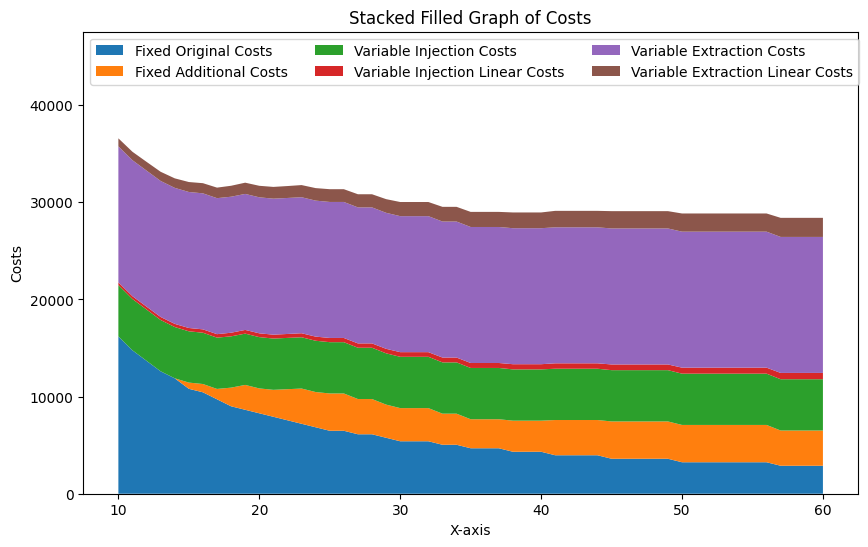

In [298]:
# Costs

costs = np.array([
    fixed_original_costs,
    fixed_additional_costs,
    variable_injection_costs,
    variable_injection_linear_costs,
    variable_extraction_costs,
    variable_extraction_linear_costs
])
max_value = np.sum(costs, axis=0).max() / len(hexagons_to_draw)
labels = [
    'Fixed Original Costs',
    'Fixed Additional Costs',
    'Variable Injection Costs',
    'Variable Injection Linear Costs',
    'Variable Extraction Costs',
    'Variable Extraction Linear Costs'
]
fig, ax = plt.subplots(figsize=(10, 6))
scaled_costs = [[cost/len(hexagons_to_draw) for cost in costs_i] for costs_i in costs]
ax.stackplot(tuz_capas, scaled_costs, labels=labels)
ax.legend(loc='upper left', ncol=3)
ax.set_ylim(0, 1.3 * max_value)
plt.xlabel('X-axis')
plt.ylabel('Costs')
plt.title('Stacked Filled Graph of Costs')
plt.show()


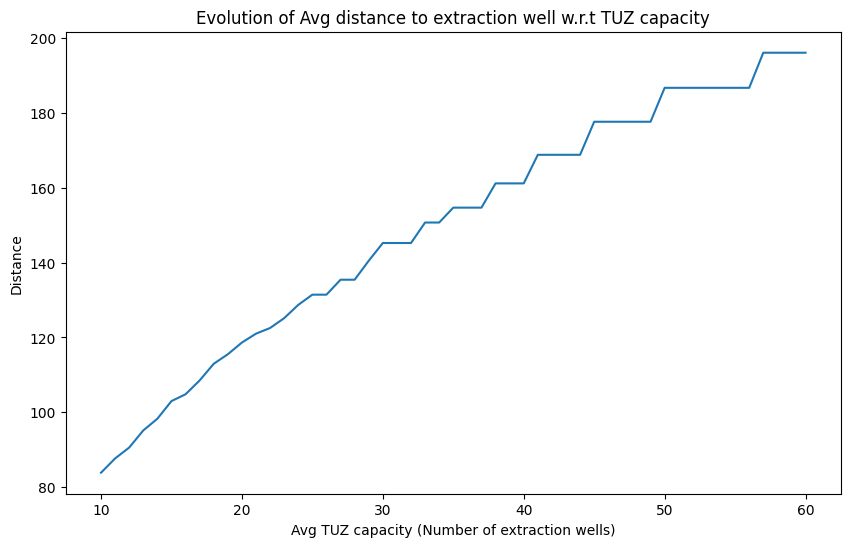

In [301]:
plt.figure(figsize=(10, 6))
plt.plot(tuz_capas, distances_extraction_wells)
plt.xlabel('Avg TUZ capacity (Number of extraction wells)')
plt.ylabel('Distance')
plt.title('Evolution of Avg distance to extraction well w.r.t TUZ capacity')
plt.show()

In [ ]:
# Distances extraction wells


In [294]:
np.sum(costs, axis=1)

array([1.38510000e+08, 6.81600000e+07, 1.21176000e+08, 1.13285954e+07,
       3.21300000e+08, 3.43875681e+07])

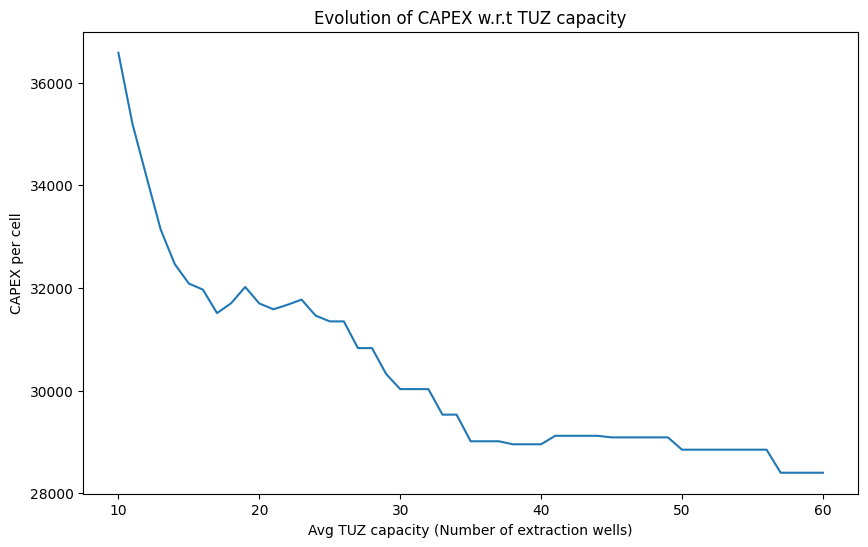

In [271]:
fixed_costs = costs
total_costs = [a+b for a, b in zip(fixed_costs, variable_costs)]

cost_per_cell = [cost / len(hexagons_to_draw) for cost in total_costs]
plt.figure(figsize=(10, 6))
plt.plot(tuz_capas, cost_per_cell)
plt.xlabel('Avg TUZ capacity (Number of extraction wells)')
plt.ylabel('CAPEX per cell')
plt.title('Evolution of CAPEX w.r.t TUZ capacity')
plt.show()

In [ ]:
# mettre à jour le cout des CAPEX --> JB

# pour chaque scénario : 
# - plot nb tuzs en f° de Avg Tuz capa
# - plot distance moyenne aux puits extracteurs en f° de Avg Tuz capa - 
# - ajouter sur la courbe des couts les contributions des costs buckets - OK

# Etudes sur différentes géographies de gisements

# OPEX : 21 000 $ / TUZ de 17 / an


#### TESTS AND NOTES

In [136]:
CAPEX = {
    "fixed": {
        "original": 122_000, 
        "additional": 68_000, 
    }, 
    "variable_injection": {
        "fixed": 2_600, 
        "variable": 0.21, 
    }, 
    "variable_extraction": {
        "fixed": 4_200, 
        "variable": 1.2, 
    },
}

122_000 + 68_000 + 16.7*(4_200 + 63.7*1.2) + 36.7*(2_600 + 67.7*0.21)

357358.31190000003

In [106]:
# Valeur : 
# OEE / vitesse d'extraction / disponibilité tuz => convertie en $

# augmenttaion des m3 extraits ou augmentation de la concentration solution => tous les 2 sont convertibles en euros
# somme des leviers : 1.7 M par an => x 5 (5 ans) => 

36.7 injection points on average


In [97]:
for i, tuz in tuzs.items():
    print(i, ":", len(tuz["extraction_points"]))

0 : 18
1 : 21
2 : 18
3 : 15
4 : 15
5 : 15
6 : 18
7 : 18
8 : 18
9 : 18
10 : 21
11 : 15
12 : 12
13 : 18
14 : 21
15 : 15
16 : 15
17 : 18
18 : 18
19 : 15
20 : 18
21 : 15
22 : 15
23 : 15
24 : 12
25 : 15
26 : 18


In [77]:
tuzs

{0: {'x': 24.267857142857142, 'y': 11.619174167441217, 'z': 0},
 1: {'x': 10.05952380952381, 'y': 10.53664241271067, 'z': 0},
 2: {'x': 31.705357142857142, 'y': 11.43875220831946, 'z': 0},
 3: {'x': 23.442857142857143, 'y': 23.151745794503988, 'z': 0},
 4: {'x': 41.08035714285714, 'y': 11.87176491021168, 'z': 0},
 5: {'x': 3.4285714285714306, 'y': 22.35170327862694, 'z': 0},
 6: {'x': 7.042857142857143, 'y': 2.829016319029167, 'z': 0},
 7: {'x': 36.392857142857146, 'y': 4.85936476567935, 'z': 0},
 8: {'x': 40.58035714285714, 'y': 21.83105705373272, 'z': 0},
 9: {'x': 24.976190476190474, 'y': 3.4641016151377553, 'z': 0},
 10: {'x': 14.071428571428571, 'y': 22.640378413221754, 'z': 0},
 11: {'x': 16.70807453416149, 'y': 12.651501550937885, 'z': 0},
 12: {'x': 30.48901098901099, 'y': 21.31754840084772, 'z': 0},
 13: {'x': 2.80952380952381, 'y': 15.107332043795207, 'z': 0},
 14: {'x': 35.74812030075188, 'y': 17.18376722245965, 'z': 0},
 15: {'x': 18.892857142857142, 'y': 3.897114317029974,